# 10. 프로젝트: CAM을 만들고 평가해 보자

## 루브릭

|평가문항|	상세기준|
|:-------|:-------|
|1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?|ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.|
|2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?|CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.|
|3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?|CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.|

* [참고: Class Activation Map(Learning Deep Features for Discriminative Localization)](https://kangbk0120.github.io/articles/2018-02/cam)

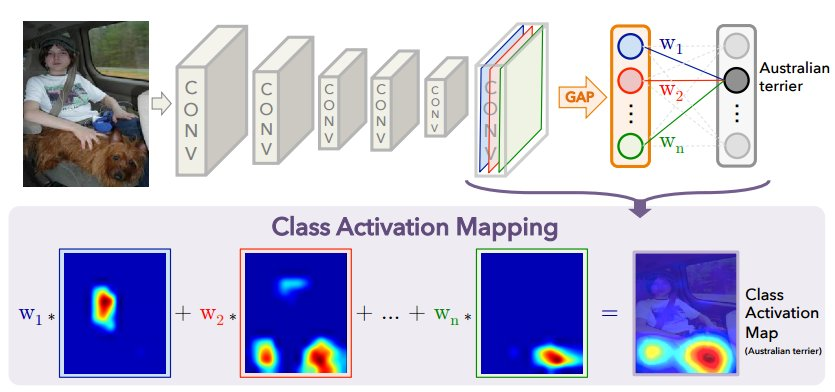

## CAM 구현하기

1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

### 데이터셋 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image
import os

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

# 데이터셋 다운로드
(ds_train, ds_test), ds_info = tfds.load(name='cars196',
                                        split=['train', 'test'],
                                        shuffle_files=True,
                                        with_info=True,
                                        )

### 데이터셋 정보 확인

In [4]:
# 데이터셋 정보 확인
ds_info

tfds.core.DatasetInfo(
    name='cars196',
    full_name='cars196/2.0.0',
    description="""
    The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.
    """,
    homepage='https://ai.stanford.edu/~jkrause/cars/car_dataset.html',
    data_path='/home/aiffel-d34j/tensorflow_datasets/cars196/2.0.0',
    download_size=1.82 GiB,
    dataset_size=1.85 GiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=8041, num_shards=8>,
        'train': <SplitInfo num_examples=8144, num_shards=

In [5]:
# features가 어떻게 구성되어 있는지 확인
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

In [6]:
# 데이터셋 features의 keys 정보 확인
sorted(ds_info.features.keys())

['bbox', 'image', 'label']

In [7]:
# 데이터 개수 확인
print('train :', ds_info.splits['train'])
print('test  :', ds_info.splits['test'])

train : <SplitInfo num_examples=8144, num_shards=8>
test  : <SplitInfo num_examples=8041, num_shards=8>


In [8]:
# 데이터 개수 확인 
print('train :', tf.data.experimental.cardinality(ds_train))
print('test  :', tf.data.experimental.cardinality(ds_test))

train : tf.Tensor(8144, shape=(), dtype=int64)
test  : tf.Tensor(8041, shape=(), dtype=int64)


In [9]:
# 클래스의 개수 확인
num_classes = ds_info.features["label"].num_classes
print('class 개수 :', num_classes)

class 개수 : 196


In [10]:
# 클래스의 이름 확인
ds_info.features["label"].names

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura Integra Type R 2001',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi A5 Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi V8 Sedan 1994',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi TT Hatchback 2011',
 'Audi S6 Sedan 2011',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S4 Sedan 2012',
 'Audi S4 Sedan 2007',
 'Audi TT RS Coupe 2012',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW X5 SUV 2007',
 'BMW X6 SUV 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3

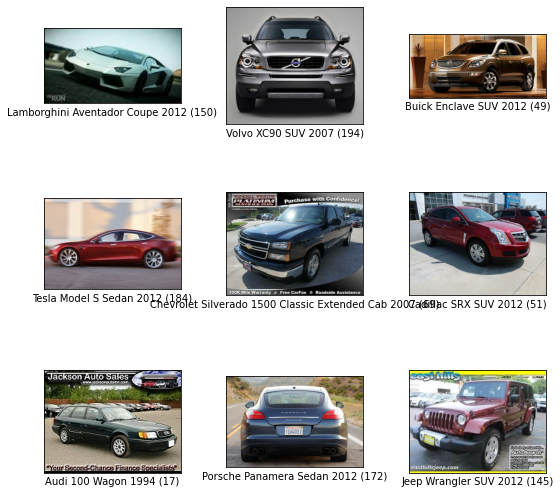

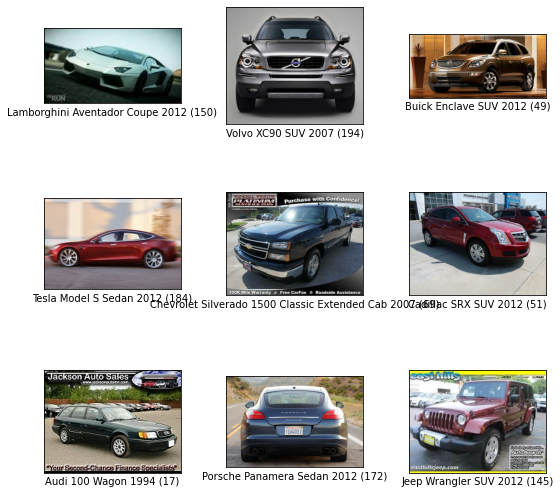

In [11]:
# 학습용 데이터셋 각 이미지의 클래스와 그 인덱스(index) 확인
tfds.show_examples(ds_train, ds_info)

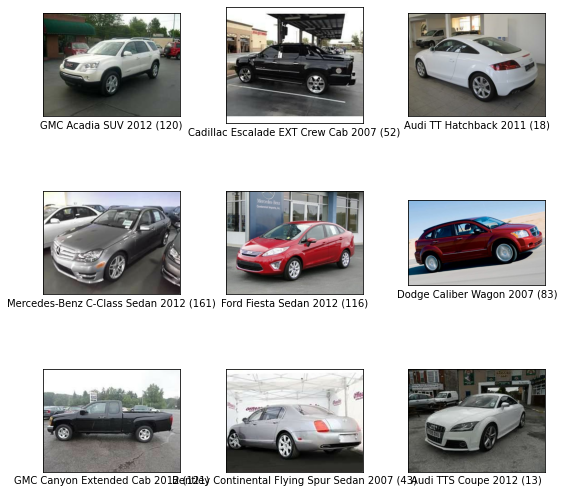

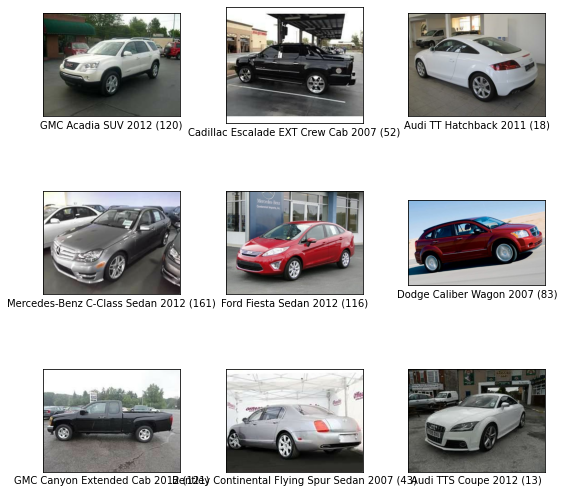

In [12]:
# 평가용 데이터셋 각 이미지의 클래스와 그 인덱스(index) 확인
tfds.show_examples(ds_test, ds_info)

### 학습된 ResNet50 모델로 부터 기본 모델 생성하기

In [13]:
# del cam_model

In [14]:
# 선행학습된 모델로부터 기준모델 만들기
base_model = keras.applications.resnet.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',        # Global Average Pooling 적용  
)

# 모든 모델의 학습가능 플레그를 False로 세팅하여 모든 레이어 고정
# base_model.trainable = False        # layer.trainable = False  # Freeze the layer

# 분류 헤드를 추가하기
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)

# 학습할 CAM모델 생성 및 확인
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

* `keras.applications.resnet.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)` : [참고](https://keras.io/ko/applications/)
  - include_top: 네트워크의 최상단에 완전 연결 레이어를 넣을지 여부.
  - weights: None (임의의 초기값 설정) 혹은 'imagenet' (ImageNet에 대한 선행 학습) 중 하나.
  - input_tensor: 모델의 이미지 인풋으로 사용할 수 있는 선택적 케라스 텐서 (다시말해, layers.Input()의 아웃풋).
  - input_shape: 선택적 형태 튜플로, include_top이 False일 경우만 특정하십시오.
  - pooling: 특성추출을 위한 선택적 풀링 모드로, include_top이 False일 경우 유효합니다.
    - None은 모델의 아웃풋이 마지막 컨볼루션 레이어의 4D 텐서 아웃풋임을 의미합니다.
    - 'avg'는 글로벌 평균값 풀링이 마지막 컨볼루션 레이어의 아웃풋에 적용되어 모델의 아웃풋이 2D 텐서가 됨을 의미합니다.
    - 'max'는 글로벌 최대값 풀링이 적용됨을 의미합니다.
  - classes: 이미지를 분류하기 위한 선택적 클래스의 수로, 
    - include_top이 True일 경우, 그리고 weights 인수가 따로 정해지지 않은 경우만 특정합니다.


* [참고: 텐서플로우 전이학습](https://east-rain.github.io/docs/Deep%20Learning/tensorflow%20tutorial/image_transfer_learning_preTrained.html)

* [참고: 전이 학습 및 미세 조정](https://www.tensorflow.org/guide/keras/transfer_learning?hl=ko)

* [참고: 미리 학습된 ConvNet으로 부터 전이 학습](https://east-rain.github.io/docs/Deep%20Learning/tensorflow%20tutorial/image_transfer_learning_preTrained.html)

* [참고: ResNet50을 사용한 ImageNet 클래스 분류](https://keras.io/ko/applications/)
  - 모든 레이어 고정
    - `for layer in base_model.layers:`  
           layer.trainable = False

  - `base_model.output` :

  - `base_model.input` :




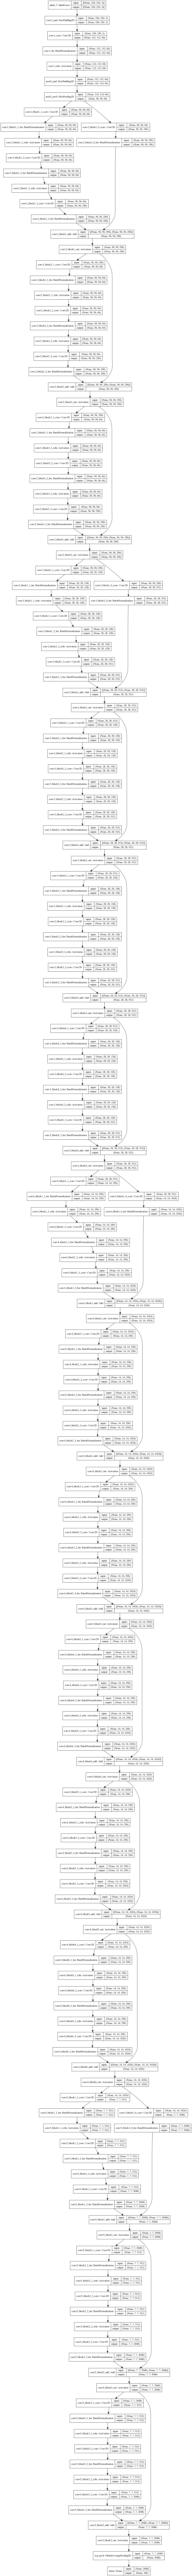

In [15]:
tf.keras.utils.plot_model(cam_model, show_shapes=True)

### CAM 모델 학습하기

In [16]:
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 16

In [17]:
# 데이터 전처리 함수
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

# 데이터 배치처리 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [18]:
# 데이터셋에 전처리와 배치처리 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)


# 구성된 배치의 모양 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [19]:
import math

# 학습율 감소 함수
def lr_step_decay(epoch):
    init_lr = 0.01          # self.flag.initial_learning_rate
    lr_decay = 0.5           # self.flag.learning_rate_decay_factor
    epoch_per_decay = 5     # self.flag.epoch_per_decay
    lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
    return lrate

In [20]:
from tensorflow.keras.callbacks import LearningRateScheduler

# learning schedule callback
learning_rate = LearningRateScheduler(lr_step_decay)
callbacks_list = [learning_rate]

In [21]:
from tensorflow.keras.optimizers import *

tf.random.set_seed(2021)

# 모델 학습과정 설정하기
cam_model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  )
# 모델 학습시키기
history_cam_model = cam_model.fit_generator(
    generator=ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=20,
    callbacks = callbacks_list,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
509/509 [==============================] - 130s 194ms/step - loss: 4.9311 - accuracy: 0.0614 - val_loss: 5.4517 - val_accuracy: 0.0046
Epoch 2/20
509/509 [==============================] - 86s 169ms/step - loss: 2.0988 - accuracy: 0.5383 - val_loss: 1.9448 - val_accuracy: 0.5073
Epoch 3/20
509/509 [==============================] - 86s 169ms/step - loss: 0.7108 - accuracy: 0.8677 - val_loss: 1.3188 - val_accuracy: 0.6576
Epoch 4/20
509/509 [==============================] - 86s 169ms/step - loss: 0.1690 - accuracy: 0.9844 - val_loss: 1.1000 - val_accuracy: 0.7033
Epoch 5/20
509/509 [==============================] - 86s 169ms/step - loss: 0.0470 - accuracy: 0.9995 - val_loss: 1.0674 - val_accuracy: 0.7115
Epoch 6/20
509/509 [==============================] - 86s 169ms/step - loss: 0.0525 - accuracy: 0.9984 - val_loss: 1.0467 - val_accuracy: 0.7174
Epoch 7/20
509/509 [==============================] - 92s 181ms/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 1.0533 - val_a

In [22]:
# 학습시킨 모델 저장
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

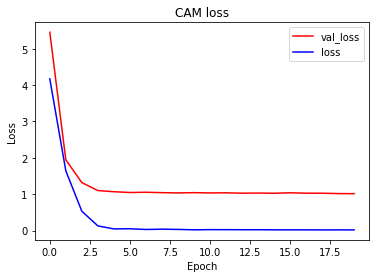

In [23]:
# 훈련 과정 loss 시각화
plt.plot(history_cam_model.history['val_loss'], 'r')
plt.plot(history_cam_model.history['loss'], 'b')
plt.title('CAM loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'loss'], loc='upper right')
plt.show()

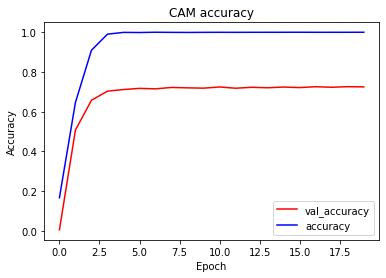

In [24]:
# 훈련 과정 accuracy 시각화
plt.plot(history_cam_model.history['val_accuracy'], 'r')
plt.plot(history_cam_model.history['accuracy'], 'b')
plt.title('CAM accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['val_accuracy', 'accuracy'], loc='lower right')
plt.show()

### 학습된 모델을 활용한 CAM 생성

In [25]:
# 데이터셋에서 한 장씩 가져오는 함수
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

116


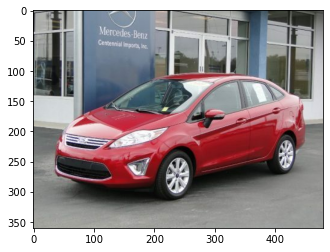

In [41]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [42]:
# 학습한 모델 불러오기
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [43]:
# 입력 이미지와 동일한 크기의 CAM을 반환하는 함수
def generate_cam(model, item):
    cam_image = None
    
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model(inputs=[model.inputs], 
                                      outputs=[model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] # 모델의 마지막 레이어에서 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    
    return cam_image

* 모델의 메소드들과 속성들 : [참고](https://keras.io/ko/models/about-keras-models/)
  - model.layers: 모델을 구성하는 층들이 저장된 1차원 리스트
  - model.inputs: 모델의 입력 텐서들이 저장된 1차원 리스트
  - model.outputs: 모델의 출력 텐서들이 저장된 1차원 리스트
  - model.summary(): 모델의 구조를 요약해 출력
  - model.get_config(): 모델의 설정이 저장된 딕셔너리
  - model.get_weights(): 모델의 가중치 텐서들이 NumPy 배열로 저장된 1차원 리스트
  - model.set_weights(weights): 모델의 가중치 값을 NumPy 배열의 리스트로부터 설정

2) 만든 함수로 CAM 이미지를 생성합시다.

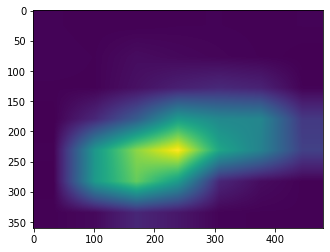

In [44]:
# generate_cam 함수 적용
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

3) 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

$$merged\_ image ~=~ \alpha \cdot img1 ~+~ \beta \cdot img2 ~+~ \gamma$$

In [81]:
# 원본과 CAM을 겹쳐 보여주는 함수
def visualize_cam_on_image(image, cam_image, alpha=0.2):
#     img1 = cv2.imread(image)
#     img2 = cv2.imread(cam_image)

#     # 블렌딩하는 두 이미지의 크기가 같아야함
#     width = img1.shape[1]
#     height = img1.shape[0]
#     img2 = cv2.resize(img2, (width, height))
    
    # image 사진은 점점 투명해지고 cam_image 사진은 점점 불투명해짐
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    
    return merged_image

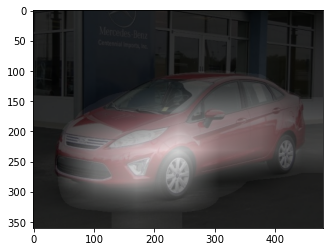

In [82]:
# visualize_cam_on_image() 함수 사용
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(origin_image, cam_image_3channel)
plt.imshow(blended_image)

## Grad-CAM 구현하기

1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

In [47]:
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    # 정규화 및 크기 변경
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 모델의 input과 output 새롭게 정의
    grad_model = tf.keras.models.Model(inputs=[model.inputs], 
                                       outputs=[model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx]   # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0]     # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    # gradient의 GAP으로 class별 weight를 구합니다.
    weights = np.mean(grad_val, axis=(0, 1)) 
    
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    
    # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)   # 정규화
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))   # 이미지 크기 복원

    return grad_cam_image

* `tf.expand_dims(img_tensor, 0)` :
* `tape.gradient(loss, conv_output)` :
* `axis=(0, 1)` :

2) 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

In [48]:
# 레이어의 이름 확인
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

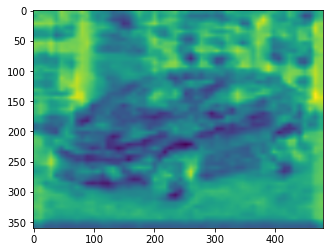

In [49]:
grad_cam_image = generate_grad_cam(cam_model, 'conv2_block3_out', item)
plt.imshow(grad_cam_image)

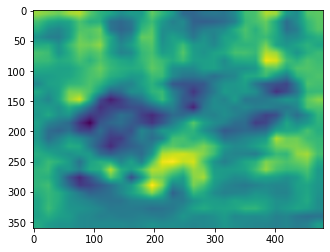

In [50]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block4_out', item)
plt.imshow(grad_cam_image)

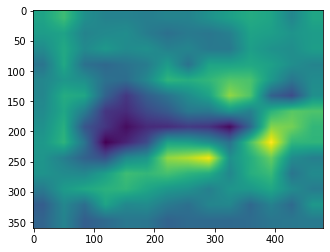

In [51]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block6_out', item)
plt.imshow(grad_cam_image)

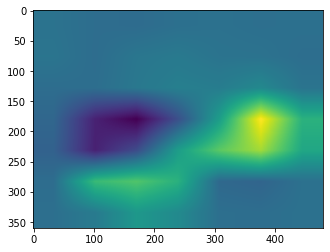

In [52]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

3) 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

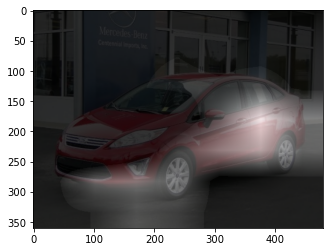

In [83]:
# visualize_cam_on_image() 함수 사용
grad_origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

grad_blended_image = visualize_cam_on_image(grad_origin_image, grad_cam_image_3channel)
plt.imshow(grad_blended_image)

## 바운딩 박스 구하기

1) 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

In [54]:
def get_bbox(cam_image, score_thresh=0.05):
    # 임계값 이하의 바운딩 박스 제거
    low_indicies = cam_image <= score_thresh     
    cam_image[low_indicies] = 0
    
    # 정규화 복원
    cam_image = (cam_image*255).astype(np.uint8)
    
    # 사각형 찾기
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]     # 찾은 contour들 중에서 첫번째 contour
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    
    return rect

* `cv2.findContours()` : [참고](https://blog.naver.com/samsjang/220516822775)
  - 이미지에서 contour를 찾은 후 리스트형 자료에 담아 리턴한다.
  - 하나의 contour는 1xN 크기의 numpy array 이다.
  
* `cv2.RETR_TREE` :
* `cv2.CHAIN_APPROX_SIMPLE` :

* `cv2.minAreaRect()` : [참고](https://blog.naver.com/samsjang/220517391218)
  - 인자로 입력한 contour에 외접하면서 면적이 가장 작은 직사각형을 구한다.
  - 리턴값은 좌상단 꼭지점 좌표(x, y), 가로 및 세로의 폭과 이 사각형이 기울어진 각도이다.
  
* `cv2.boxPoints()` : [참고](https://blog.naver.com/samsjang/220517391218)
  - `cv2.minAreaRect()`함수로 얻은 직사각형의 꼭지점 4개의 좌표를 얻는다.
  - 리턴값은 float 형의 좌표값 이다.
  
* `np.int0()` : [참고](https://blog.naver.com/samsjang/220517391218)
  - float형 값을 정수형 값으로 전환한다.

2) 1)에서 얻은 바운딩 박스를 시각화해 보세요.

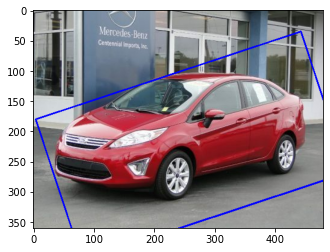

In [55]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)

image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)

* `cv2.drawContours(image, [rect], 0, (0,0,255), 2)` : [참고](https://blog.naver.com/samsjang/220516822775)
  - 찾은 사각형 contour에 대해서 모든 픽셀의 두께를 2로, 선의 색은 파란색(0,0,255)으로 하여 image 위에 드로잉한다.

## IoU 구하기

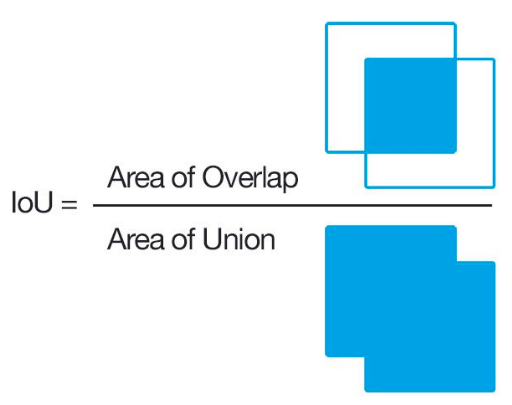

1) 정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.

In [56]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]),  #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1])   #bounding box의 x_max
    ]
    return bbox

In [57]:
# rect의 꼭지점 좌표
rect = get_bbox(cam_image)
rect

array([[  4, 180],
       [443,  35],
       [520, 268],
       [ 81, 413]])

In [58]:
# 위에서 구했던 rect를 minmax bbox 형태로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09722222222222222,
 0.008333333333333333,
 1.1472222222222221,
 1.0833333333333333]

In [59]:
# 이 데이터의 ground truth bbox를 확인
item['bbox']

array([0.29166666, 0.075     , 0.875     , 0.94375   ], dtype=float32)

In [60]:
# IoU 계산하는 함수
def get_iou(gt_bbox, pred_bbox):
    iou = None
    
    y_min = max(gt_bbox[0], pred_bbox[0])
    x_min = max(gt_bbox[1], pred_bbox[1])
    y_max = min(gt_bbox[2], pred_bbox[2])
    x_max = min(gt_bbox[3], pred_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    box_gtArea = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    box_predArea = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    iou = interArea / float(box_gtArea + box_predArea - interArea)
    
    return iou

In [61]:
get_iou(pred_bbox, item['bbox'])

0.44896647515619065

2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

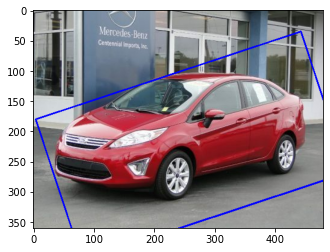

In [62]:
# CAM으로 얻은 바운딩 박스
image = copy.deepcopy(item['image'])
rect_cam = get_bbox(cam_image)

image_cam = cv2.drawContours(image, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image_cam)

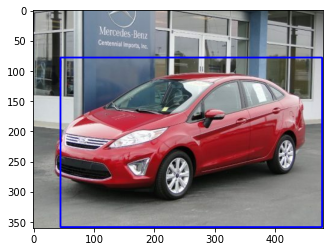

In [63]:
# Grad-CAM으로 얻은 바운딩 박스
image = copy.deepcopy(item['image'])
rect_grad_cam = get_bbox(grad_cam_image)

image_grad_cam = cv2.drawContours(image, [rect_grad_cam], 0, (0,0,255), 2)
plt.imshow(image_grad_cam)

In [65]:
# 이미지 크기
image.shape[0], image.shape[1]

(360, 480)

In [84]:
# 정답 바운딩 박스 꼭지점 좌표
box_gt = item['bbox']      # 정규화된 좌표

y1 = int(box_gt[0]*image.shape[0])   # 복원된 좌표
x1 = int(box_gt[1]*image.shape[1])

y2 = int(box_gt[2]*image.shape[0])
x2 = int(box_gt[3]*image.shape[1])

box_gt = (x1, y1), (x2, y2)
box_gt

((36, 104), (453, 315))

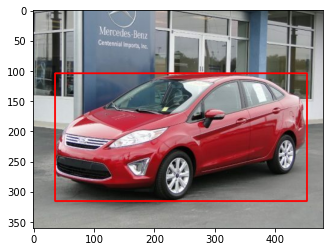

In [78]:
# 정답 바운딩 박스
image = copy.deepcopy(item['image'])
image_gt_box = cv2.rectangle(image, (36, 104), (453, 315), (255,0,0), 2)
plt.imshow(image_gt_box)

In [79]:
# CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU
pred_bbox_cam = rect_to_minmax(rect_cam, item['image'])
get_iou(pred_bbox_cam, item['bbox'])

0.44896647515619065

In [80]:
# Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU
pred_bbox_grad_cam = rect_to_minmax(rect_grad_cam, item['image'])
get_iou(pred_bbox_grad_cam, item['bbox'])

0.6958499544800669

## 회고

* OpenCV, Pillow 등 이미지 처리 프로그램을 좀 더 학습해야겠다.

* 학습된 모델을 사용하는 방법을 좀 더 찾아보자.